In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("GPU Available:", tf.test.is_gpu_available())


import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
import FeatureExtraction
from importlib import reload
import transformers
import random
from transformers import Transformers
import scipy.signal as signal
from skimage.restoration import denoise_wavelet
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU, Flatten
from tensorflow.keras import layers, models
from keras.models import Sequential,Model
from keras.layers import LeakyReLU
from keras.utils import plot_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
reload(Preprocessing)


2024-05-15 20:14:28.188540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 20:14:28.487357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 20:14:28.491115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 20:14:28.550569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 20:14:28.759102: I tensorflow/core/platform/cpu_feature_guar

[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-15 20:14:32.163144: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-15 20:14:32.166901: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: blue
2024-05-15 20:14:32.166929: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: blue
2024-05-15 20:14:32.168579: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-05-15 20:14:32.168628: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-05-15 20:14:32.168636: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


GPU Available: False


<module 'Preprocessing' from '/home/donya/Documents/Electrocardiogram/ECG-diagnosis/Preprocessing.py'>

In [4]:
load = Preprocessing.preprocess()
X = load.loadSignal()

In [4]:
np.save('original_signals.npy', X)

In [3]:
originalsignals = np.load('original_signals.npy')

In [13]:
origin_signals = np.transpose(X, (0, 2, 1))

In [ ]:
loaded_highpassfiltered_signals = np.load('highpass_filtered.npy')

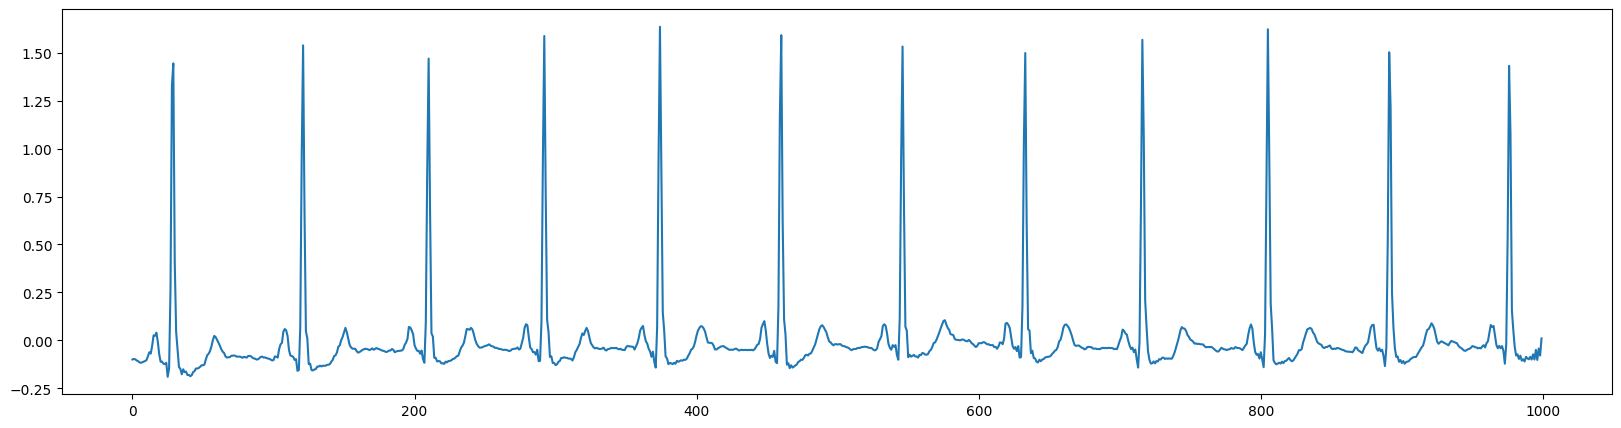

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(originalsignals[500].T[0][:])

loading the signals

In [3]:
load = Preprocessing.preprocess()
X = load.loadSignal()


""" a 3D array of shape (19601, 12, 1000) where the first dimension represents the number of ECG signals,
 the second dimension represents the number of leads, and the third dimension represents the length of each signal. """


 
origin_signals = np.zeros((21799, 12, 1000))
# origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        
        origin_signals[sig, lead, :] = X[sig].T[lead][:] 

# for sig in range(x_test.shape[0]):
#     for lead in range(x_test.shape[2]):
        
#         origin_test_signals[sig, lead, :] = x_test[sig].T[lead][:] 



""" highpassedfiltered are just baseline removed """
# loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')


""" 'bandpass_filtered.npy' contains signals that have been thourogh 
baseline removal + moving avg + bandpass filter [0.5 - 25] """ 

# loaded_bandpassedfiltered_signal = np.load('bandpass_filtered_25.npy')

" 'bandpass_filtered.npy' contains signals that have been thourogh \nbaseline removal + moving avg + bandpass filter [0.5 - 25] "

In [6]:
x = np.load('wavelet_filtered.npy')


x = np.transpose(x, (0,2,1))

In [ ]:
np.save('wavelet_filtered_newshape.npy', x)

In [ ]:
import numpy as np 

x = np.load('wavelet_filtered.npy')
type(x)

In [5]:
# reload(Preprocessing)
import Preprocessing
load = Preprocessing.preprocess()
database = load.loadStatement()
# database = database.reset_index()

"""  (NORM: normal ECG, CD: conduction disturbance,
MI: myocardial infarction, HYP: hypertrophy, and STTC:
ST-T changes)  """

'  (NORM: normal ECG, CD: conduction disturbance,\nMI: myocardial infarction, HYP: hypertrophy, and STTC:\nST-T changes)  '

In [10]:
database

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [ ]:
database.diagnostic_superclass.value_counts()

In [69]:
database['diagnostic_superclass'] = database['diagnostic_superclass'].apply(lambda x: ['Unknown'] if len(x) == 0 else x)


In [ ]:
for i in range(21799):
    print(database.diagnostic_superclass[i])

Load Data Version 2 


In [2]:
import utils
import numpy as np
from importlib import reload

reload(utils)

sampling_frequency=100
datafolder=''
task='superdiagnostic'
# outputfolder='../output/'

# Load PTB-XL data
# data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
data = np.load('/home/donya/Documents/electrocardiogram/ptb-xl/highpass_filtered.npy')
raw_labels = utils.load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
signals, dataset, labels, _ = utils.select_data(data, labels, task, min_samples=0)

Freq Analysis

In [54]:
loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
# loaded_waveletfiltered_signals = loaded_waveletfiltered_signals.astype('float32')

In [ ]:
import numpy as np 

loaded_highpassfiltered_signals = np.load('highpass_filtered.npy')
loaded_highpassfiltered_signals.shape

In [22]:

lead_ii_signals = np.zeros((21799, 1000))
# origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(loaded_highpassfiltered_signals.shape[0]):
    # for lead in range(loaded_highpassfiltered_signals.shape[1]):
        
    lead_ii_signals[sig, :] = loaded_highpassfiltered_signals[sig][1][:] 

In [8]:
signals.shape

(21388, 12, 1000)

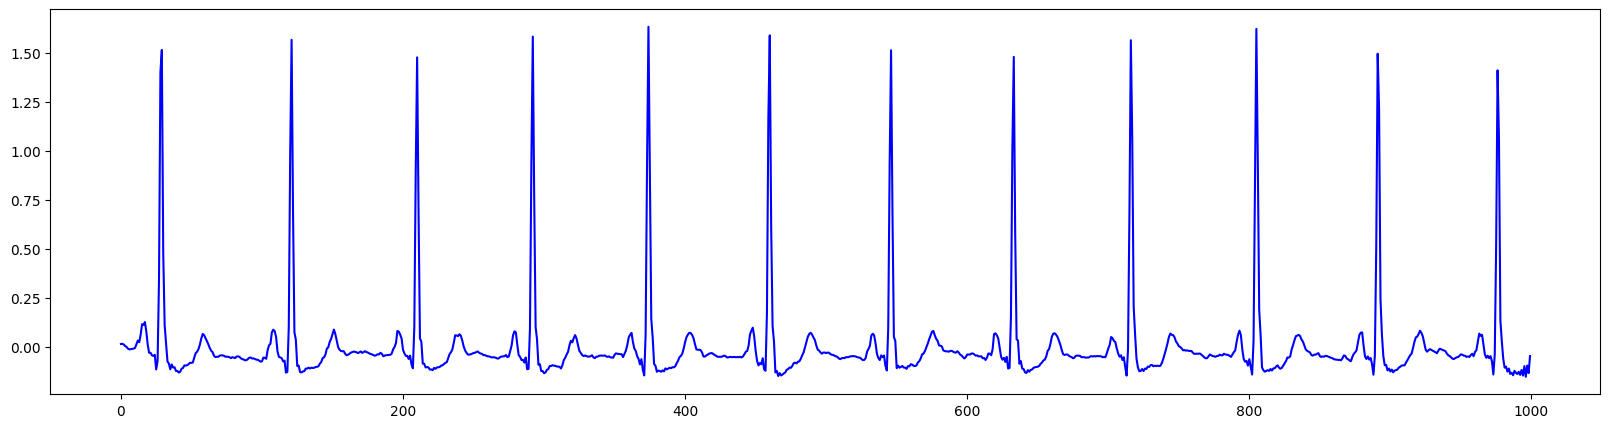

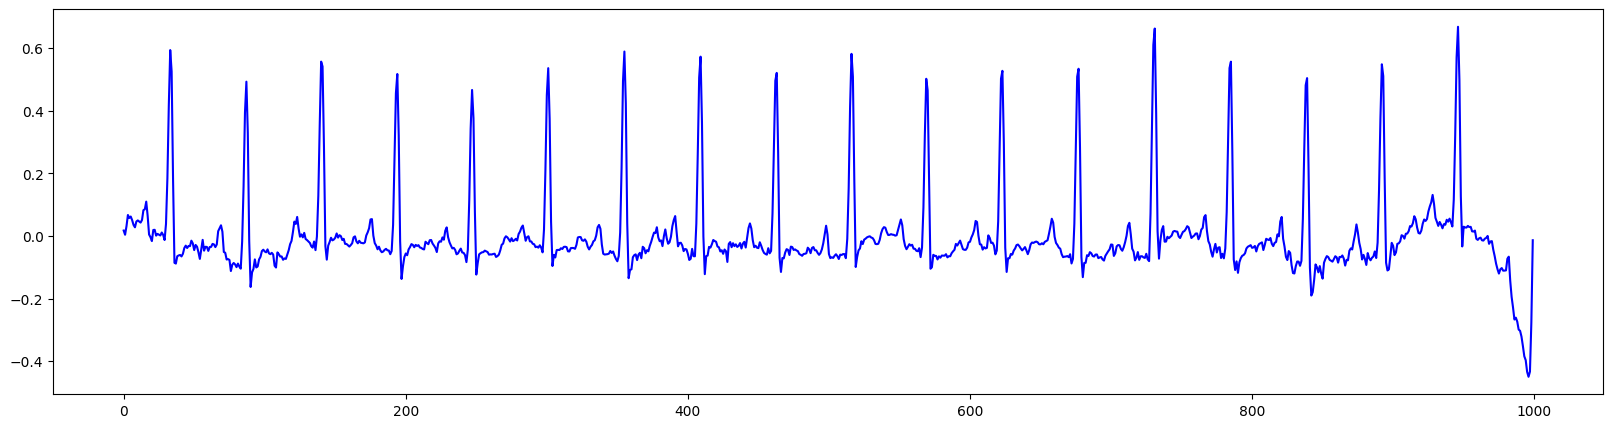

In [6]:
reload(Preprocessing)
show = Preprocessing.preprocess()
show.signalshow(data[500][0]
                )
show.signalshow(signals[500][0])

In [14]:
filter = Preprocessing.preprocess()
sample_highpass_filtered = filter.highpassfilter(origin_signals[0][0], 100, 4, 0.5)
sample_bandpass_filtered = filter.bandpassfilter(origin_signals[0][0], 100, 4, 0.1, 35)
sample_movingavg_filtered = filter.movingaveragefilter(origin_signals[0][0])

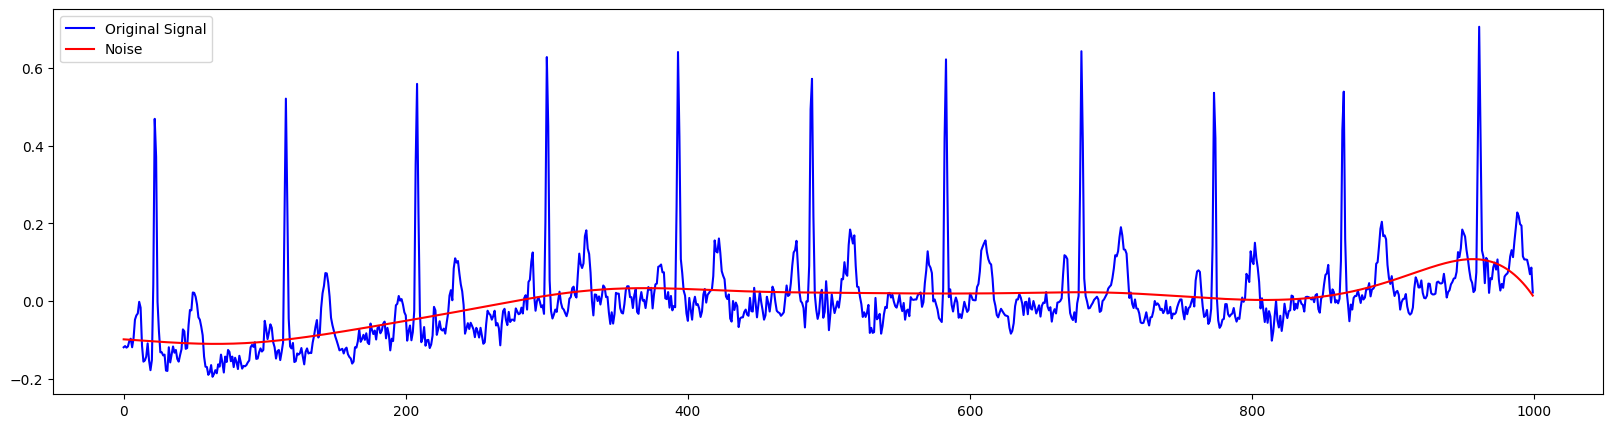

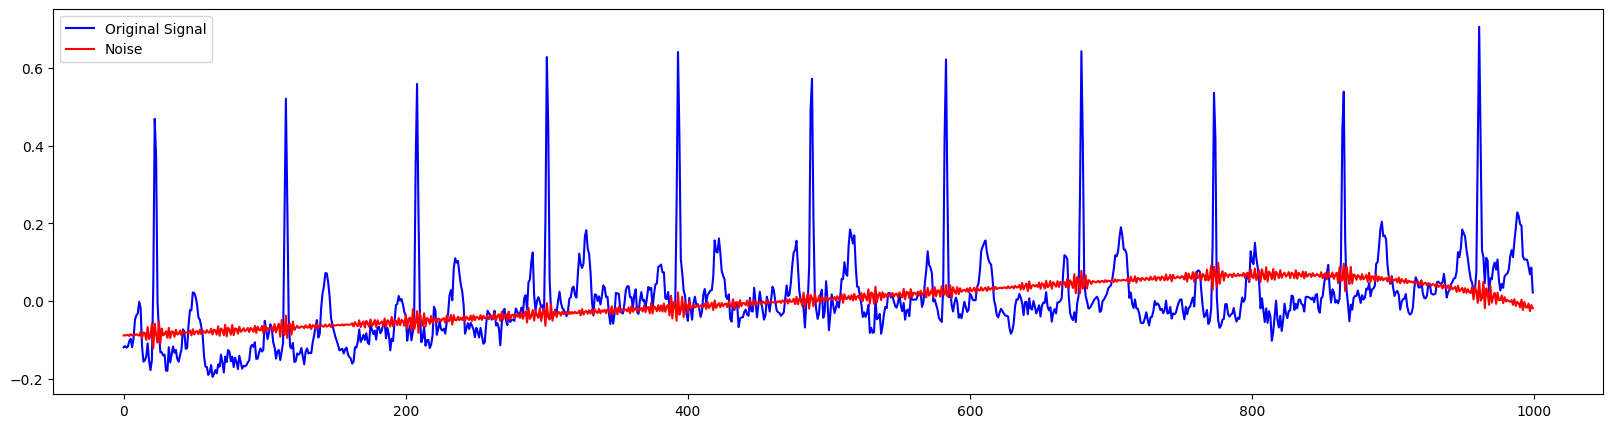

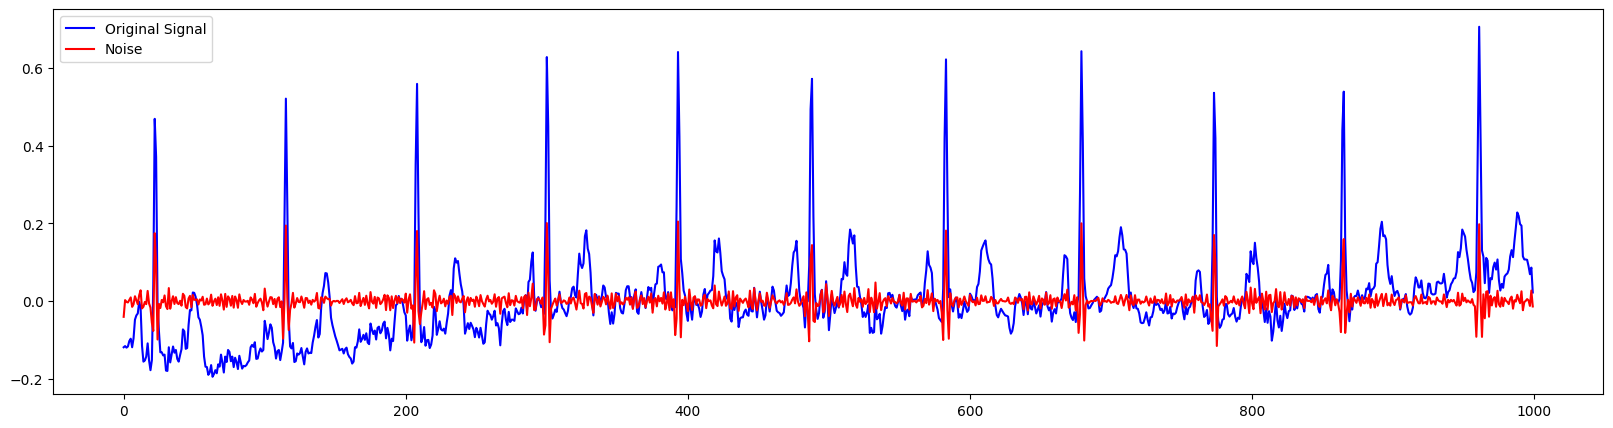

In [16]:
reload(Preprocessing)
show = Preprocessing.preprocess()

# show.noise_representation(origin_signals[0][0], loaded_waveletfiltered_signals[0][0])
show.noise_representation(origin_signals[0][0], sample_highpass_filtered)
show.noise_representation(origin_signals[0][0], sample_bandpass_filtered)
show.noise_representation(origin_signals[0][0], sample_movingavg_filtered)

In [ ]:
reload(Preprocessing)
show = Preprocessing.preprocess()

show.noise_representation(origin_signals[0][0], loaded_waveletfiltered_signals[0][0])

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(loaded_waveletfiltered_signals[0][0][:])

Noise-removal

In [5]:
reload(Preprocessing)

""" all the filtering techniques are applied to the train signals """
filter = Preprocessing.preprocess()

baseline_removed_signals, bandpassfiltered_signals, smoothedfiltered_signals = np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000))


for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):
        

        """ baseline removal """
        baseline_removed_signals[sig][lead] = filter.highpassfilter(origin_signals[sig][lead][:], 100, 4, 0.5)




In [ ]:
""" smoothing using wavelets
this changes have been applied to the baseline filtered signals """

reload(Preprocessing)
filter = Preprocessing.preprocess()
waveletfiltered_signals = np.zeros((21799, 12, 1000))
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        waveletfiltered_signals[sig][lead] = filter.wavelet_denoising(loaded_highpassedfiltered_signal[sig][lead][:])
        

In [ ]:
for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        smoothedfiltered_signals[sig][lead] = filter.movingaveragefilter(origin_signals[sig][lead][:])

np.save('movingavg_filtered.npy', bandpassfiltered_signals)
    


In [ ]:

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        """ smoothing the variations """
        bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 35)

# np.save('bandpass_filtered.npy', bandpassfiltered_signals)


Extracting Features

In [ ]:
"""  
locating the R Peaks for the entire dataset
- R_peaks should have a shape of (19601, 12), representing the R peak locations for each signal and lead.
- RR_intervals should have a shape of (19601, 12), representing the RR intervals for each signal and lead. 

"""


reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

# loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
R_peaks = []
RR_intervals = []


for signal in range(loaded_waveletfiltered_signals.shape[0]):
    # # signal_r_peaks = []
    # # for lead in signal:
    r_peaks, rr_intervals = extractor.R_peak_detection(loaded_waveletfiltered_signals[signal][1][:])
    r_peaks = np.array(r_peaks)
    # rr_intervals = np.diff(r_peaks)
    rr_intervals = np.array(rr_intervals)
    # # signal_r_peaks.append(r_peaks)
    R_peaks.append(r_peaks)
    RR_intervals.append(rr_intervals)



In [ ]:
""" 
HRV measurements are calculated from the RR intervals of an ECG signal, 
which represent the time between successive R peaks in the QRS complex.

the HR and HRV are unique for an individual, 
but the measurements obtained from different leads may show slight variations 
due to the specific placement and orientation of the electrodes used to capture the signals.
since the differences of these measuremnets among leads are neglectable,
only the lead II which is the most commonly used lead, is used for the calculations.

"""

""" 
the lead commonly used for HRV analysis is Lead II.
 """

"""        hrv_features = [
            mean_rr,
            std_rr,
            rmssd, 
            nn50, 
            pnn50, 
            total_power, 
            vlf, 
            lf, 
            hf, 
            lf_norm,
            hf_norm, 
            lf_hf_ratio, 
            total_power_log, 
        ]
        
        """
""" the shape is 21799 * 12 """

reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()
HRV_features = []

for signal in range(loaded_waveletfiltered_signals.shape[0]):
    
    HRV_features.append(extractor.calculate_hrv_features(RR_intervals[signal]))

HRV_features_DF = pd.DataFrame(HRV_features, columns= ["mean_rr",
            "std_rr",
            "rmssd", 
            "nn50", 
            "pnn50", 
            "total_power", 
            "vlf", 
            "lf", 
            "hf", 
            "lf_norm",
            "hf_norm", 
            "lf_hf_ratio", 
            # "total_power_log"
            ])

HRV_features_DF



/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 5, using nperseg = 5
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 9, using nperseg = 9
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 11, using nperseg = 11
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/donya/.local/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarnin

,mean_rr,std_rr,rmssd,nn50,pnn50,total_power,vlf,lf,hf,lf_norm,hf_norm,lf_hf_ratio
0,0.939000,0.018138,0.024944,0,0.0,0.000870,0.0,0.000000,0.000870,0.000000,1.000000,0.000000
1,1.292000,0.061123,0.064031,0,0.0,0.006753,0.0,0.000000,0.006753,0.000000,1.000000,0.000000
2,0.944444,0.022662,0.020616,0,0.0,0.000921,0.0,0.000000,0.000921,0.000000,1.000000,0.000000
3,0.806364,0.035745,0.037417,0,0.0,0.003274,0.0,0.000000,0.003274,0.000000,1.000000,0.000000
4,0.912222,0.046375,0.057446,0,0.0,0.008931,0.0,0.000000,0.008931,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
21794,0.556875,0.049840,0.090000,0,0.0,0.027749,0.0,0.001869,0.025880,0.067363,0.932637,0.072229
21795,0.894444,0.010657,0.012748,0,0.0,0.000387,0.0,0.000000,0.000387,0.000000,1.000000,0.000000
21796,1.021429,0.044858,0.061101,0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN
21797,0.859000,0.103677,0.173526,0,0.0,0.088635,0.0,0.000000,0.088635,0.000000,1.000000,0.000000


In [ ]:
""" 'age', 'sex', 'infarction_stadium1', 'infarction_stadium2', 'heart_axis ' are the used statements of data
 """


features = pd.DataFrame(index=Y.index)

features['sex'] = Y['sex']
features['age'] = Y['age']



features['infarction_stadium1'] = Y['infarction_stadium1'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

features['infarction_stadium2'] = Y['infarction_stadium2'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)


features['heart_axis'] = Y.heart_axis.replace({
    'LAD': 1,
    'ALAD': 2,
    'RAD': 3,
    'AXR': 4,
    'MID': 5,
    'ARAD': 6,
    'AXL': 7,
    'SAG': 8
}).fillna(0)


features['age'] = Y.age.replace({
    300: 30
})





""" adding hrv featres to the existing dataframe of features """

features= features.reset_index()
features = pd.concat([features, HRV_features_DF], axis=1)
features = features.drop(columns= "ecg_id")
features




,sex,age,infarction_stadium1,infarction_stadium2,heart_axis,mean_rr,std_rr,rmssd,nn50,pnn50,total_power,vlf,lf,hf,lf_norm,hf_norm,lf_hf_ratio
0,1,56.0,0.0,0.0,0.0,0.939000,0.018138,0.024944,0,0.0,0.000870,0.0,0.000000,0.000870,0.000000,1.000000,0.000000
1,0,19.0,0.0,0.0,0.0,1.292000,0.061123,0.064031,0,0.0,0.006753,0.0,0.000000,0.006753,0.000000,1.000000,0.000000
2,1,37.0,0.0,0.0,0.0,0.944444,0.022662,0.020616,0,0.0,0.000921,0.0,0.000000,0.000921,0.000000,1.000000,0.000000
3,0,24.0,0.0,0.0,0.0,0.806364,0.035745,0.037417,0,0.0,0.003274,0.0,0.000000,0.003274,0.000000,1.000000,0.000000
4,1,19.0,0.0,0.0,0.0,0.912222,0.046375,0.057446,0,0.0,0.008931,0.0,0.000000,0.008931,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,1,67.0,0.0,0.0,1.0,0.556875,0.049840,0.090000,0,0.0,0.027749,0.0,0.001869,0.025880,0.067363,0.932637,0.072229
21795,0,30.0,4.0,0.0,5.0,0.894444,0.010657,0.012748,0,0.0,0.000387,0.0,0.000000,0.000387,0.000000,1.000000,0.000000
21796,1,59.0,0.0,0.0,5.0,1.021429,0.044858,0.061101,0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN
21797,1,64.0,0.0,0.0,1.0,0.859000,0.103677,0.173526,0,0.0,0.088635,0.0,0.000000,0.088635,0.000000,1.000000,0.000000


In [ ]:
""" issue: when the total power of the heart rate variability spectrum is extremely low or close to zero
is causes the total_power_log to have an infinite value, so i cant scale them.
so i need to handel this and replace these infinite values with another number, like a large value out of my data range (99999) """

In [223]:
r_peaks_df_tf =r_peaks_df.transpose()
r_peaks_df_tf

,0,1,2,3,4,5,6,7,8,9,10
0,22,115,208,300,393,487,583,679,773,864,961


In [111]:
peak_columns = [f"Peak_{i+1}" for i in range(11)]
r_peaks_df_tf.columns = peak_columns
r_peaks_df_tf

,Peak_1,Peak_2,Peak_3,Peak_4,Peak_5,Peak_6,Peak_7,Peak_8,Peak_9,Peak_10,Peak_11
0,22,115,208,300,393,487,583,679,773,864,961


In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  21799 non-null  int64  
 1   age                  21799 non-null  float64
 2   infarction_stadium1  21799 non-null  float64
 3   infarction_stadium2  21799 non-null  float64
 4   heart_axis           21799 non-null  float64
 5   mean_rr              21796 non-null  float64
 6   std_rr               21796 non-null  float64
 7   rmssd                21796 non-null  float64
 8   nn50                 21799 non-null  int64  
 9   pnn50                21796 non-null  float64
 10  total_power          21799 non-null  float64
 11  vlf                  21799 non-null  float64
 12  lf                   21799 non-null  float64
 13  hf                   21799 non-null  float64
 14  lf_norm              20030 non-null  float64
 15  hf_norm              20030 non-null 

In [51]:
features.fillna(-1, inplace=True)  # Replace NaN with -1
features.isna().sum()

sex                    0
age                    0
infarction_stadium1    0
infarction_stadium2    0
heart_axis             0
mean_rr                0
std_rr                 0
rmssd                  0
nn50                   0
pnn50                  0
total_power            0
vlf                    0
lf                     0
hf                     0
lf_norm                0
hf_norm                0
lf_hf_ratio            0
dtype: int64

In [ ]:
""" Handling Missing Data: Imputation, Group by Label
issue: the problem is that trying to calculate the hrv features i have null values in my features dataframe 
the lf_norm, hf_norm, lf_hf_ratio,  pnn50, rmssd, std_rr, mean_rr contain null values. so i desiced to impute 
missing values in features dataframe based on the labels, the missing values are imputed 
with the mean (or median) of the features within the same label category.  """

# features_with_labels = features
# features_with_labels['label'] = Y.diagnostic_superclass
# features_with_labels


columns_with_null = ['lf_norm', 'hf_norm', 'lf_hf_ratio', 'pnn50', 'rmssd', 'std_rr', 'mean_rr']

label_means = features.groupby('label')[columns_with_null].transform('mean')

# features[columns_with_null] = features[columns_with_null].fillna(label_means)



In [28]:
joblib.dump(features, 'features.joblib')

['features.joblib']

In [5]:
features = joblib.load('features.joblib')

In [7]:
features.columns

Index(['sex', 'age', 'infarction_stadium1', 'infarction_stadium2',
       'heart_axis', 'mean_rr', 'std_rr', 'rmssd', 'nn50', 'pnn50',
       'total_power', 'vlf', 'lf', 'hf', 'lf_norm', 'hf_norm', 'lf_hf_ratio'],
      dtype='object')

In [ ]:
features.drop('lf_norm')

In [7]:
database

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [9]:
""" defining the target labels """
import pandas as pd

labels = pd.DataFrame(0, index = database.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP', 'Unknown'], dtype='int')

for i in labels.index:
    for j in database.loc[i, 'diagnostic_superclass']:
        labels.loc[i, j] = 1


# labels = labels.reset_index()
# labels.drop(columns= "ecg_id")
labels



,NORM,MI,STTC,CD,HYP,Unknown
ecg_id,,,,,,
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0
...,...,...,...,...,...,...
21833,0,0,1,0,0,0
21834,1,0,0,0,0,0
21835,0,0,1,0,0,0


In [185]:
labels.iloc[17]

NORM       0
MI         0
STTC       0
CD         0
HYP        0
Unknown    1
Name: 17, dtype: int64

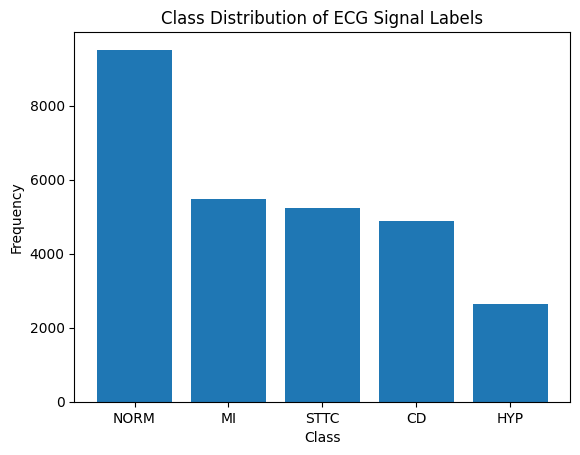

In [34]:
# Sum the rows to get the total count of each label
label_counts = labels.sum(axis=0)

# Get the labels from the column names of the DataFrame
class_labels = labels.columns

# Create a bar chart to show the class distribution
plt.bar(class_labels, label_counts)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution of ECG Signal Labels')
plt.show()

In [4]:
""" each lead represents a separate one-dimensional sequence of data points over time """

""" a 1D CNN can learn to extract meaningful features from each lead individually
    and combine them for classification or analysis. """

In [ ]:
""" an issue with the indexes of your dataframes and arrays not matching,
 it's important to ensure that the order of data in both the dataframe and signals array is aligned """

In [56]:
Y_scaler = MinMaxScaler()
lead_ii_signals_scaled = Y_scaler.fit_transform(lead_ii_signals)

In [80]:
""" its almost 80% train, 10% percent test and 10% validation """

# Training data
# X_train = features[database.strat_fold <= 8]
Y_train = lead_ii_signals_scaled[np.where(database.strat_fold <= 8)]
Z_train = y_encoded[database.strat_fold <= 8]

# Cross Valuation Data
# X_val = features[database.strat_fold == 9]
Y_val = lead_ii_signals_scaled[np.where(database.strat_fold == 9)]
Z_val = y_encoded[database.strat_fold == 9]

# Test data
# X_test = features[database.strat_fold == 10]
Y_test = lead_ii_signals_scaled[np.where(database.strat_fold == 10)]
Z_test = y_encoded[database.strat_fold == 10]


# ensure shapes match
# print(f'X_train: {X_train.shape} Y_train: {Y_train.shape} Z_train: {Z_train.shape}')
# print(f'X_val: {X_val.shape} Y_val: {Y_val.shape} Z_val: {Z_val.shape}')
# print(f'X_test: {X_test.shape} Y_test: {Y_test.shape} Z_test: {Z_test.shape}')

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(database['diagnostic_superclass'])


In [187]:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [37]:
Y_scaler = MinMaxScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

In [9]:
del origin_signals

In [56]:
del Y_train_scaled

In [57]:
del Y_val_scaled,Y_test_scaled

In [24]:
X_train_scaled.shape[1:]

(17,)

Model

In [192]:
# X model
X_input = tf.keras.layers.Input(X_train_scaled.shape[1:], name="X_input")
X = Dense(128, activation='relu', name="X_dense_1")(X_input)
X = Dropout(0.2, name="X_dropout_1")(X)
X = Dense(128, activation='relu', name="X_dense_2")(X)
X = Dropout(0.2, name="X_dropout_2")(X)
X = Dense(64, activation='relu', name="X_dense_3")(X)
X = Dropout(0.2, name="X_dropout_3")(X)
X = Dense(32, activation='relu', name="X_dense_4")(X)
outputX = Dense(Z_train.shape[-1], activation='sigmoid', name="X_dense_5")(X)

modelX = tf.keras.Model(inputs=X_input, outputs=outputX)

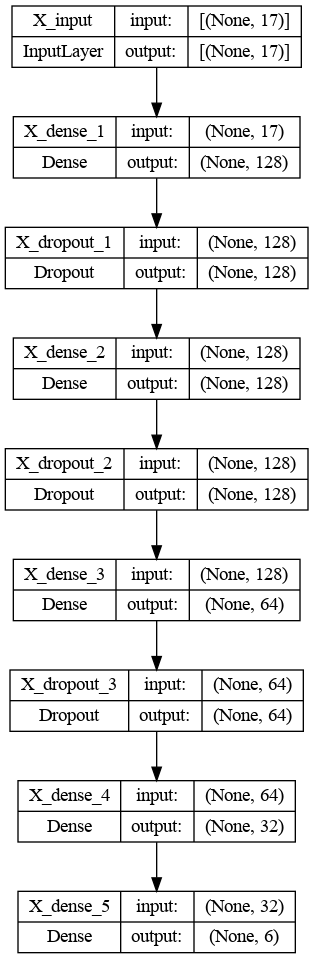

In [239]:
modelX.compile(optimizer= keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
tf.keras.utils.plot_model(modelX, show_shapes=True)
plot_model(modelX, show_shapes=True, show_layer_names=True)

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')


In [31]:
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [109]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

    
modelX.compile(
    loss = 'binary_crossentropy',
    optimizer = keras.optimizers.legacy.Adam(),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

history = modelX.fit(
    X_train, Z_train, epochs = 50, batch_size=32, validation_data=(X_val, Z_val)
)

Epoch 1/50
545/545 [==============================] - 7s 10ms/step - loss: 0.5800 - binary_accuracy: 0.7391 - precision: 0.4487 - recall: 0.1063 - val_loss: 0.4961 - val_binary_accuracy: 0.7919 - val_precision: 0.7109 - val_recall: 0.3116
Epoch 2/50
545/545 [==============================] - 6s 11ms/step - loss: 0.4946 - binary_accuracy: 0.7825 - precision: 0.6931 - recall: 0.2623 - val_loss: 0.4868 - val_binary_accuracy: 0.7890 - val_precision: 0.7524 - val_recall: 0.2584
Epoch 3/50
545/545 [==============================] - 6s 11ms/step - loss: 0.4775 - binary_accuracy: 0.7901 - precision: 0.7214 - recall: 0.2869 - val_loss: 0.4725 - val_binary_accuracy: 0.7930 - val_precision: 0.7227 - val_recall: 0.3069
Epoch 4/50
545/545 [==============================] - 4s 7ms/step - loss: 0.4709 - binary_accuracy: 0.7928 - precision: 0.7281 - recall: 0.2981 - val_loss: 0.4688 - val_binary_accuracy: 0.7934 - val_precision: 0.7343 - val_recall: 0.2986
Epoch 5/50
545/545 [=========================

In [112]:
score = modelX.evaluate(X_test, Z_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.4501584470272064
Test accuracy: 0.8035485744476318


In [32]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall'])


/tmp/ipykernel_85259/3488858524.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, 'b', color='red',label='Validation accuracy')
/tmp/ipykernel_85259/3488858524.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')


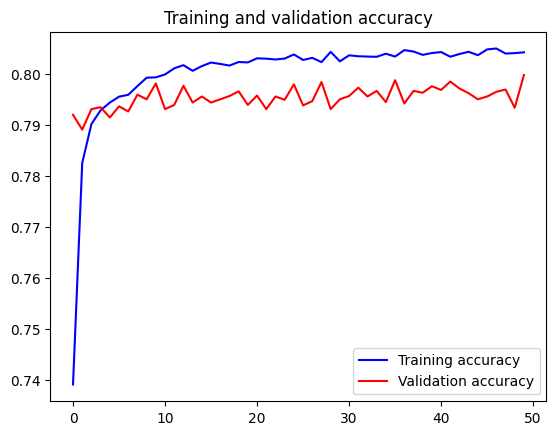

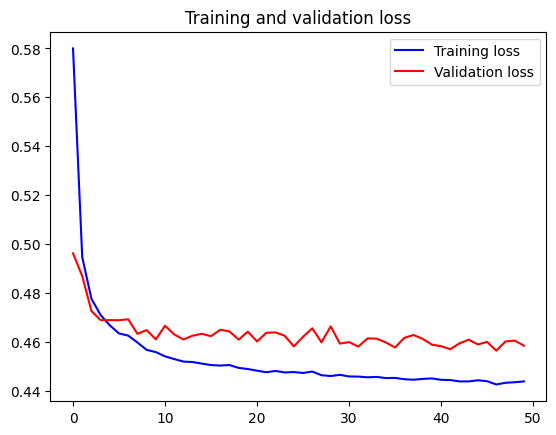

In [114]:
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', color='red',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [193]:
modelX.compile(
    loss = 'binary_crossentropy',
    optimizer = keras.optimizers.legacy.Adam(),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

history = modelX.fit(
    X_train, Z_train, epochs = 30, batch_size=32, validation_data=(X_val, Z_val)
)


Epoch 1/30
545/545 [==============================] - 4s 6ms/step - loss: 0.4928 - binary_accuracy: 0.7831 - precision: 0.4829 - recall: 0.0950 - val_loss: 0.4356 - val_binary_accuracy: 0.8096 - val_precision: 0.6956 - val_recall: 0.2072
Epoch 2/30
545/545 [==============================] - 3s 6ms/step - loss: 0.4269 - binary_accuracy: 0.8168 - precision: 0.6974 - recall: 0.2646 - val_loss: 0.4119 - val_binary_accuracy: 0.8231 - val_precision: 0.7391 - val_recall: 0.2770
Epoch 3/30
545/545 [==============================] - 3s 6ms/step - loss: 0.4134 - binary_accuracy: 0.8223 - precision: 0.7280 - recall: 0.2800 - val_loss: 0.4087 - val_binary_accuracy: 0.8227 - val_precision: 0.7125 - val_recall: 0.2976
Epoch 4/30
545/545 [==============================] - 3s 6ms/step - loss: 0.4074 - binary_accuracy: 0.8248 - precision: 0.7370 - recall: 0.2911 - val_loss: 0.4069 - val_binary_accuracy: 0.8235 - val_precision: 0.7329 - val_recall: 0.2848
Epoch 5/30
545/545 [============================

Test loss: 0.3872363269329071
Test accuracy: 0.8308310508728027


/tmp/ipykernel_85259/1969531046.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, 'b', color='red',label='Validation accuracy')
/tmp/ipykernel_85259/1969531046.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')


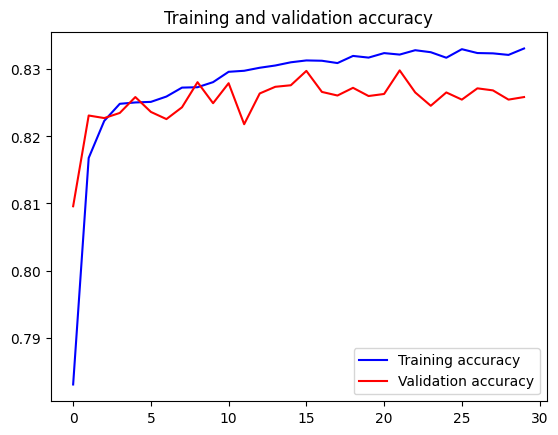

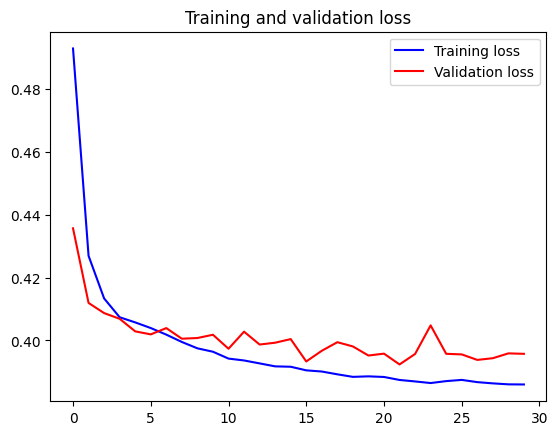

In [194]:
score = modelX.evaluate(X_test, Z_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', color='red',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

SVM - features

In [222]:
target = database['diagnostic_superclass'].apply(lambda x: x[0])

X_train = features[database.strat_fold != 10]
X_test = features[database.strat_fold == 10]

train_target = target[database.strat_fold != 10]
test_target = target[database.strat_fold == 10]
label_encoder = LabelEncoder()

encoded_train_target = label_encoder.fit_transform(train_target)
encoded_test_target = label_encoder.fit_transform(test_target)



In [224]:
svm_classifier = SVC(kernel='rbf', gamma='scale')

svm_classifier.fit(X_train, encoded_train_target)

pred_target = svm_classifier.predict(X_test)

accuracy = accuracy_score(encoded_test_target, pred_target)

print("Accuracy:", accuracy)

Accuracy: 0.5095541401273885


In [238]:
X_train_scaled.shape[1:]

(17,)

In [ ]:
model = Sequential()
model.add(Conv1D(32, kernel_size=3,activation='linear',input_shape=X_train.shape[1:],padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(2,padding='same'))
model.add(Conv1D(64, 3, activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))                   
model.add(Dense(6, activation='softmax'))

In [30]:
Y_train.shape[1:]


(1000,)

Signals

In [ ]:
model_signal = Sequential()
model_signal.add(Conv1D(32, kernel_size=3, input_shape=Y_train.shape[1:],padding='same'))
model_signal.add(LeakyReLU(alpha=0.1))
model_signal.add(MaxPooling1D(2,padding='same'))
model_signal.add(Conv1D(64, 3, activation='linear',padding='same'))
model_signal.add(LeakyReLU(alpha=0.1))
model_signal.add(MaxPooling1D(pool_size=2,padding='same'))
model_signal.add(Flatten())
model_signal.add(Dense(128, activation='linear'))
model_signal.add(LeakyReLU(alpha=0.1))
model_signal.add(Dropout(0.5))                   
model_signal.add(Dense(6, activation='softmax'))


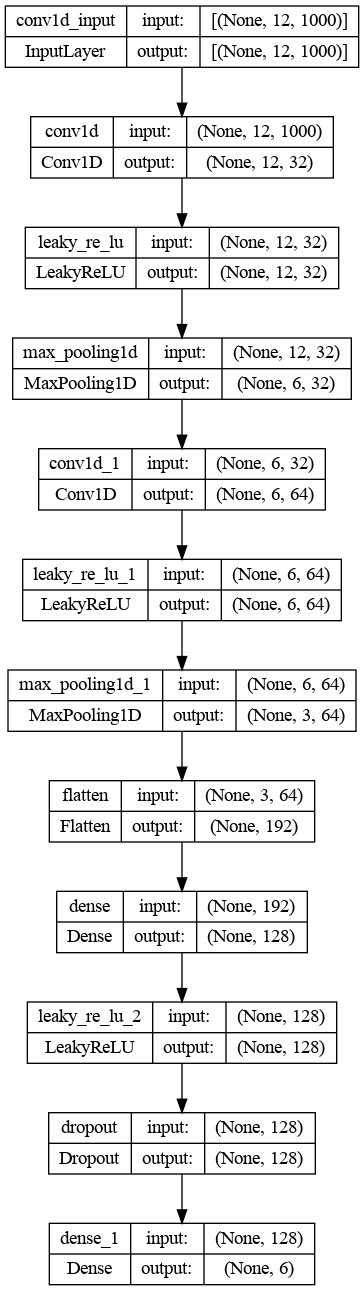

In [7]:
model_signal.compile(optimizer= keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
tf.keras.utils.plot_model(model_signal, show_shapes=True)
plot_model(model_signal, show_shapes=True, show_layer_names=True)

In [11]:
print(Y_train.shape)
print(Z_train.shape)


(17418, 12, 1000)
(17418, 6)


In [19]:
type(Z_train.iloc[
    0])


pandas.core.series.Series

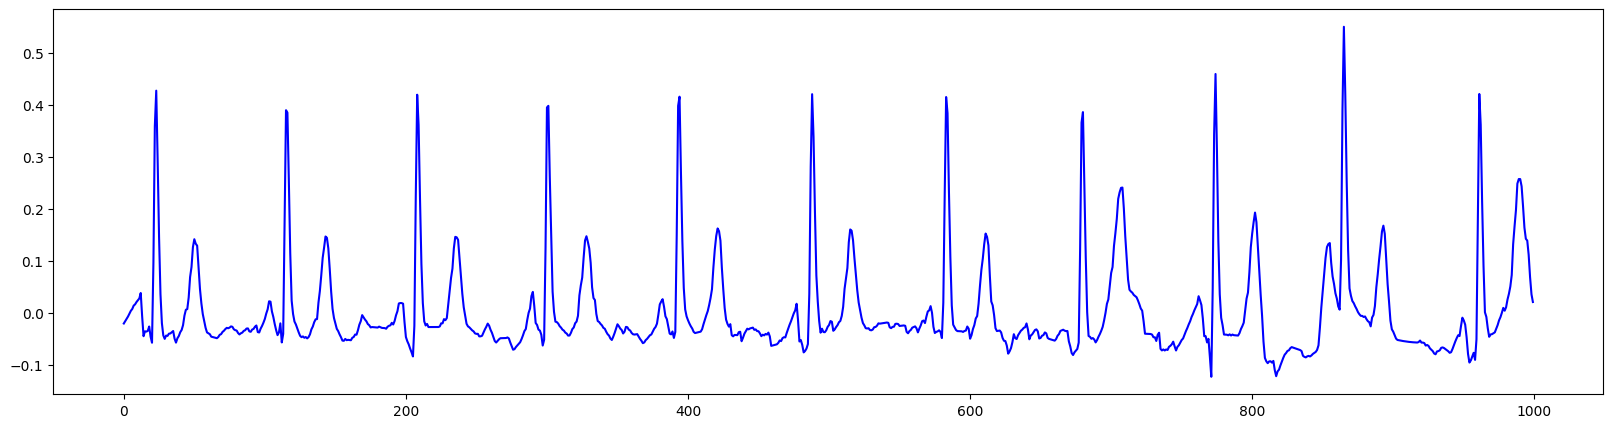

In [15]:
show.signalshow(Y_train[0][11])

In [ ]:
model_signal.fit(Y_train, Z_train, epochs=20, batch_size=128, validation_data=(Y_val,Z_val))

In [51]:
Y_train.shape[1:]

(1000,)

In [82]:
model_signal = keras.Sequential([
    tf.keras.layers.Reshape((Y_train.shape[1:][0], 1), input_shape=Y_train.shape[1:]),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(128, activation='linear'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dense(6, activation='softmax')
])


model_signal.compile(optimizer= keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# tf.keras.utils.plot_model(model_signal, show_shapes=True)
# plot_model(model_signal, show_shapes=True, show_layer_names=True)
model_signal.fit(Y_train, Z_train, batch_size=64, epochs=10, validation_data=(Y_val, Z_val))



Epoch 1/10
273/273 [==============================] - 14s 39ms/step - loss: 2.0960 - accuracy: 0.4931 - val_loss: 21.9765 - val_accuracy: 0.2268
Epoch 2/10
273/273 [==============================] - 10s 37ms/step - loss: 2.2222 - accuracy: 0.5065 - val_loss: 3.3940 - val_accuracy: 0.4343
Epoch 3/10
273/273 [==============================] - 10s 37ms/step - loss: 2.6069 - accuracy: 0.5216 - val_loss: 4.7020 - val_accuracy: 0.3733
Epoch 4/10
273/273 [==============================] - 10s 37ms/step - loss: 3.0123 - accuracy: 0.5319 - val_loss: 13.6527 - val_accuracy: 0.1470
Epoch 5/10
273/273 [==============================] - 10s 37ms/step - loss: 3.8674 - accuracy: 0.5310 - val_loss: 15.4139 - val_accuracy: 0.1379
Epoch 6/10
273/273 [==============================] - 10s 37ms/step - loss: 4.3095 - accuracy: 0.5478 - val_loss: 15.8190 - val_accuracy: 0.1548
Epoch 7/10
273/273 [==============================] - 10s 37ms/step - loss: 5.0013 - accuracy: 0.5412 - val_loss: 15.9240 - val_accu

In [84]:
model_signal.evaluate(Y_val, Z_val)

69/69 [==============================] - 1s 10ms/step - loss: 13.8552 - accuracy: 0.2597


[13.855194091796875, 0.25973430275917053]

In [11]:
del model_signal

Concatenation

In [ ]:

Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y = Conv1D(64, 5, activation=ReLU, padding='same')(Y_input)
Y = Conv1D(128, 3, activation=ReLU, padding='same')(Y)
# Y = BatchNormalization(name="Y_norm_1")(Y)
# Y = ReLU(name="Y_relu_1")(Y)
Y = MaxPooling1D(2,strides=2 ,name="Y_max_1")(Y)
Y = Dropout(0.2, name="Z_dropout_2")(Y)

Y = Conv1D(128, 13, strides=1, activation=ReLU, padding='same')(Y)
Y = Conv1D(256, 7, strides=1, activation=ReLU, padding='same')(Y)
# Y = BatchNormalization(name="Y_norm_2")(Y)
# Y = ReLU(name="Y_relu_2")(Y)
Y = MaxPooling1D(2,strides=2, name="Y_max_2")(Y)

Y = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y)
Y = BatchNormalization(name="Y_norm_3")(Y)
Y = ReLU(name="Y_relu_3")(Y)
Y = GlobalAveragePooling1D(name="Y_global")(Y)

Y = Dropout(0.4, name="Y_dropout")(Y)
Y = Dense(64, activation='relu', name="Z_dense_1")(Y)
Y = Dropout(0.4, name="Z_dropout_1")(Y)
Y = Dense(64, activation='relu', name="Z_dense_2")(Y)
Y = Dropout(0.4, name="Z_dropout_2")(Y)
output = Dense(6, activation="sigmoid", name="Z_dense_3")(Y)

modelZ = tf.keras.Model(inputs=Y_input, outputs=output)


modelZ.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.legacy.Adam(),
    metrics=['binary_accuracy', 'Precision', 'Recall']
)


modelZ.summary()

In [247]:

Z = Concatenate(name="Z_concat")([outputX, signal_featuremap])
Z = Dense(64, activation='relu', name="Z_dense_1")(Z)
Z = Dropout(0.4, name="Z_dropout_1")(Z)
Z = Dense(64, activation='relu', name="Z_dense_2")(Z)
Z = Dropout(0.4, name="Z_dropout_2")(Z)
output = Dense(6, activation="sigmoid", name="Z_dense_3")(Z)

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)


modelZ.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.legacy.Adam(),
    metrics=['binary_accuracy', 'Precision', 'Recall']
)


modelZ.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Y_input (InputLayer)        [(None, 12, 1000)]           0         []                            
                                                                                                  
 Y_conv_1 (Conv1D)           (None, 12, 32)               96032     ['Y_input[0][0]']             
                                                                                                  
 Y_norm_1 (BatchNormalizati  (None, 12, 32)               128       ['Y_conv_1[0][0]']            
 on)                                                                                              
                                                                                                  
 Y_relu_1 (ReLU)             (None, 12, 32)               0         ['Y_norm_1[0][0]']     

                                                                                                  
 X_dropout_2 (Dropout)       (None, 128)                  0         ['X_dense_2[0][0]']           
                                                                                                  
 Y_conv_3 (Conv1D)           (None, 3, 128)               24704     ['Y_max_2[0][0]']             
                                                                                                  
 X_dense_3 (Dense)           (None, 64)                   8256      ['X_dropout_2[0][0]']         
                                                                                                  
 Y_norm_3 (BatchNormalizati  (None, 3, 128)               512       ['Y_conv_3[0][0]']            
 on)                                                                                              
                                                                                                  
 X_dropout

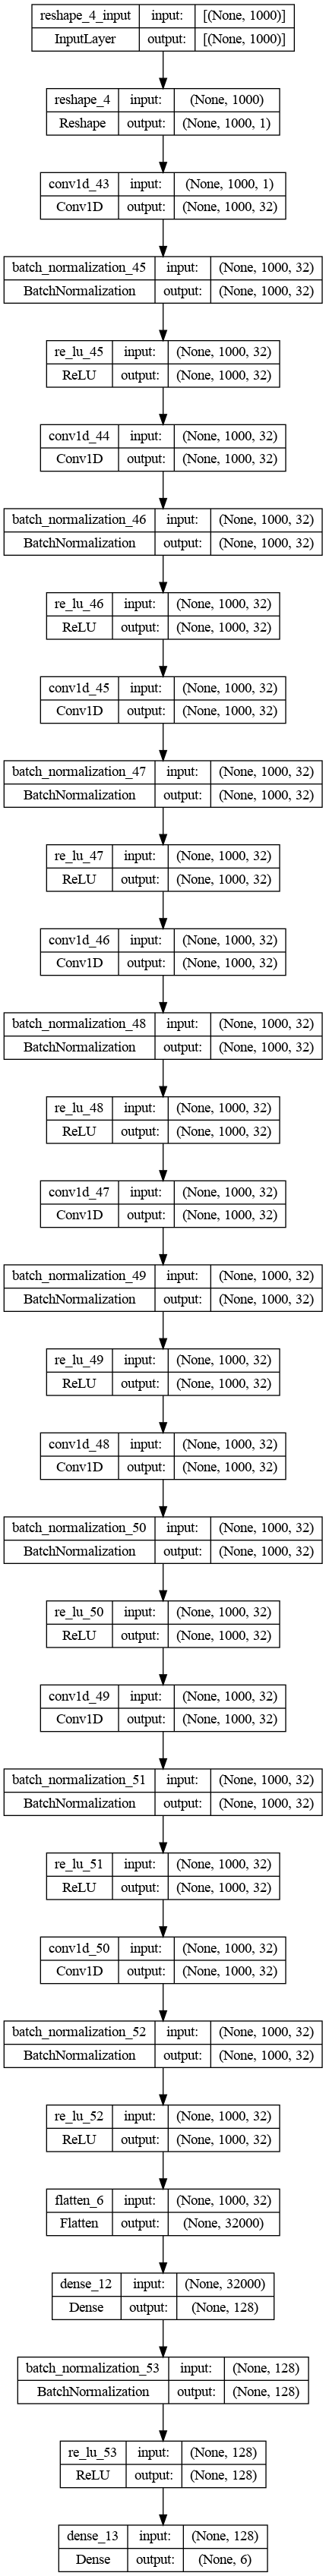

In [40]:
tf.keras.utils.plot_model(model_signal, show_shapes=True)
plot_model(model_signal, show_shapes=True, show_layer_names=True)

In [249]:

fitting = modelZ.fit(
    [X_train, Y_train_scaled], Z_train, epochs=20, batch_size=32, validation_data=([X_val, Y_val_scaled], Z_val)
)

: 

In [27]:
modelX.evaluate(X_test_scaled, Z_test)

69/69 [==============================] - 0s 5ms/step - loss: 1.8775 - binary_accuracy: 0.6806 - precision: 0.3938 - recall: 0.4767


[1.8774998188018799, 0.680618941783905, 0.3937869966030121, 0.4767192006111145]

Just Playing With the Signal

In [45]:
Y_train = loaded_waveletfiltered_signals[np.where(database.strat_fold <= 8)]
Y_val = loaded_waveletfiltered_signals[np.where(database.strat_fold == 9)]
Y_test = loaded_waveletfiltered_signals[np.where(database.strat_fold == 10)]

print(f'Y_train: {Y_train.shape} Y_val: {Y_val.shape} Y_test: {Y_test.shape}')


Y_train: (17418, 12, 1000) Y_val: (2183, 12, 1000) Y_test: (2198, 12, 1000)


In [10]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

In [11]:
Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y_output = Conv1D(32, 3, padding='same', name="Y_conv_1")(Y_input)
Y_output = BatchNormalization(name="Y_norm_1")(Y_output)
Y_output = ReLU(name="Y_relu_1")(Y_output)
Y_output = MaxPooling1D(2, name="Y_max_1")(Y_output)

Y_output = Conv1D(64, 3, padding='same', name="Y_conv_2")(Y_output)
Y_output = BatchNormalization(name="Y_norm_2")(Y_output)
Y_output = ReLU(name="Y_relu_2")(Y_output)
Y_output = MaxPooling1D(2, name="Y_max_2")(Y_output)

Y_output = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y_output)
Y_output = BatchNormalization(name="Y_norm_3")(Y_output)
Y_output = ReLU(name="Y_relu_3")(Y_output)

Y_output = GlobalAveragePooling1D(name="Y_global")(Y_output)


# Fully connected layer with softmax activation
Y_output =Dense(5, activation='softmax')(Y_output)

model = tf.keras.Model(inputs=Y_input, outputs= Y_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

2023-10-30 20:38:45.362312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 20:38:45.363259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 20:38:45.364001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Y_input (InputLayer)        [(None, 12, 1000)]        0         
                                                                 
 Y_conv_1 (Conv1D)           (None, 12, 32)            96032     
                                                                 
 Y_norm_1 (BatchNormalizati  (None, 12, 32)            128       
 on)                                                             
                                                                 
 Y_relu_1 (ReLU)             (None, 12, 32)            0         
                                                                 
 Y_max_1 (MaxPooling1D)      (None, 6, 32)             0         
                                                                 
 Y_conv_2 (Conv1D)           (None, 6, 64)             6208      
                                                             

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')


In [52]:
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
model.fit(Y_train_scaled, Z_train, epochs = 40, batch_size=128, validation_data=(Y_val_scaled, Z_val))

In [2]:
from biosppy import storage
from biosppy.signals import ecg

# load raw ECG signal
# signal, mdata = storage.load_txt('ecg.txt')

# process it and plot
out = ecg.ecg(signal=loaded_highpassfiltered_signals[0][1], sampling_rate=100, show=True)

NameError: name 'loaded_highpassfiltered_signals' is not defined